# SD212: Graph mining
## Lab 5: Clustering

You will learn how to cluster the nodes of a graph and to estimate the quality of the clustering. 

In [3]:
import networkx as nx
actors_movies = nx.read_graphml("actors_movies.graphml", node_type = int)

## Import

In [4]:
import networkx as nx

The documentation is available [here](https://networkx.readthedocs.io/en/stable/).

In [5]:
import numpy as np

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import matplotlib.pyplot as plt

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data

You will need the following datasets (the same as in previous labs, no need to download them again):
* [Les Misérables](http://perso.telecom-paristech.fr/~bonald/graphs/miserables.graphml.gz)<br>  Graph connecting the characters of the [novel of Victor Hugo](https://fr.wikisource.org/wiki/Les_Misérables) when they appear in the same chapter. The graph is undirected and weighted. Weights correspond to the number of chapters in which characters appear together. 
* [Openflights](http://perso.telecom-paristech.fr/~bonald/graphs/openflights.graphml.gz)<br>
Graph of the main international flights. Nodes are airports. The graph is undirected (all flights are bidirectional). Weights correspond to the number of daily flights between airports. Extracted from [Openflights](http://openflights.org).
* [Wikipedia for schools](http://perso.telecom-paristech.fr/~bonald/graphs/wikipedia_schools.graphml.gz)<br> Graph of the hyperlinks between a subset of the pages of the English Wikipedia. The graph is directed and unweighted.
More information [here](https://en.wikipedia.org/wiki/Wikipedia:Wikipedia_for_Schools).
* [Actors-Movies](http://perso.telecom-paristech.fr/~bonald/graphs/actors_movies.graphml.gz)<br>
Graph between actors and movies (a link exists if the actor stars in the movie). The graph is bipartite (see the field 'type' of each node). 
Extracted from [YaGo](http://yago-knowledge.org).

## 1. Modularity

Consider an undirected, unweighted graph of $n$ nodes and $m$ edges with adjacency matrix $A$, without self-loops.

The modularity of clustering $C$ is defined by:
$$
Q(C) = \frac 1 {2m} \sum_{i,j\in V} \left(A_{ij} - \frac {d_id_j}{2m}\right) \delta_{C(i),C(j)}
$$
where $d_i = \sum_j A_{ij}$ is the degree of node $i$.

The modularity can also be written:
$$
Q(C) = \sum_k  \frac{m_k}{m} - \sum_k  \left( \frac{v_k}{v}\right)^2
$$
where
* $m_k$ is the number of edges in cluster $k$  
* $v_k $ is the volume of cluster $k$ (total degree of nodes in the cluster)
* $v$ is the volume of the graph (total degree of nodes)

The definition extends to a weighted graph as follows:
$$
Q(C) = \sum_k  \frac{w_k}{w} - \sum_k  \left( \frac{v_k}{v}\right)^2
$$
where
* $w_k$ is the weight of cluster $k$ (total weight of edges in the cluster)
* $w$ is the weight of the graph (total weight of edges in the graph)

## Toy graph

Consider the following graph:

In [9]:
edges = [(7,5),(5,3),(3,7),(4,5),(8,6),(7,4),(1,6),(9,8),(7,8),(6,1),(2,9),(8,2),(1,9)]
graph = nx.Graph()
graph.add_edges_from(edges)

with the following clustering:

In [10]:
C = {1: 0, 2: 0, 6: 0, 8: 0, 9: 0, 3: 1, 4: 1, 5: 1, 7: 1}

Visualization:

In [11]:
pos = nx.spring_layout(graph)

In [12]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [13]:
node_colors = [colors[C[u] % len(colors)] for u in graph.nodes()]

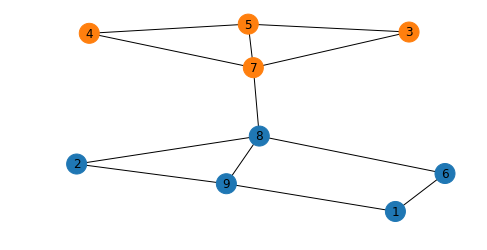

In [14]:
plt.figure(figsize = (6,3))
nx.draw(graph, pos, node_size = 400, node_color = node_colors, with_labels = True)
plt.show()

## To do

* What is the fraction of edges within clusters?
* What is the Simpson's index associated with the volume distribution between clusters?
* Deduce the modularity of the clustering. 
* What is the maximum value of modularity for 2 clusters?
* Complete the function `get_modularity` below and check it on the above graph.

Blue = 2 + 3 + 2 + 3 + 2 = 12            
Orange = 3 + 2 + 3 + 2 = 10

In [15]:
Q = 6 / 12 + 5 / 12 - (13/24)**2 - (11/24)**2
print(Q)
print("Maximum modularity of two clusters is 1 - 1/K = 0.5" )

0.41319444444444464
Maximum modularity of two clusters is 1 - 1/K = 0.5


In [16]:
def get_modularity(graph,C):
    '''
    graph: networkx graph
        undirected graph (possibly weighted)
    C: dictionary
        cluster of each node
        
    Returns: float
        modularity
    '''
    # add weights if none
    if nx.get_edge_attributes(graph,'weight') == {}:
        for u,v in graph.edges():
            graph[u][v]['weight'] = 1
            
    cluster = set(C.values())
    cluster_weight = {k: 0 for k in cluster}
    cluster_volume = {k: 0 for k in cluster}
    m = float(len(edges))
    clusters = list(C.values())
    for u,v in graph.edges():
        if (clusters[u-1] == clusters[v-1]):
            cluster_weight[clusters[u-1]] = cluster_weight[clusters[u-1]] + graph[u][v]['weight']
    for u in graph.nodes():
        summ = 0
        for x,v in graph.edges():
            if (x==u or v==u):
                summ = summ + graph[x][v]['weight']
        cluster_volume[clusters[u-1]] = cluster_volume[clusters[u-1]] + summ
    Q = 0
    for i in cluster:
        Q = Q + (cluster_weight[i] / m) - (cluster_volume[i]/(2*m))**2
        #((m1 + m2) / m) - (v1/v)**2 - (v2/v)**2
    return Q

In [17]:
get_modularity(graph, C)

0.4171597633136096

## Stochastic block model

The [stochastic block model](https://en.wikipedia.org/wiki/Stochastic_block_model) is a random graph with an underlying structure in clusters (the blocks).

In [18]:
block_sizes = [10, 15, 20]
p_in = 0.4 # probability of connection within blocks
p_out = 0.02 # probability of connection across blocks
graph = nx.random_partition_graph(sizes = block_sizes, p_in = p_in, p_out = p_out,seed = 0)
pos = nx.spring_layout(graph)

In [19]:
pos = nx.spring_layout(graph)

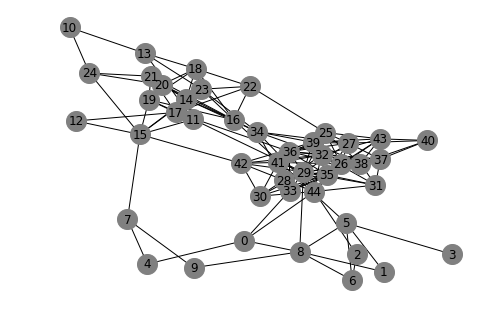

In [20]:
plt.figure(figsize = (6,4))
nx.draw(graph, pos, node_size = 400, node_color = 'gray', with_labels = True)
plt.show()

## To do

* Propose a clustering for this graph and compute the modularity.
* What is the strongest cluster? 
* Complete the function `get_cluster_strength` below and check your guess.
* Comment the results.

**Hint:** Recall that the strength of cluster $k$ is defined by: $$\frac{2w_k }{ v_k}.$$

In [21]:
C = dict([(el,0) for el in [i for i in range(10)]]+[(el,1) for el in [i for i in range(10,25)]]+[(el,2) for el in [i for i in range(25,45)]])
C

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 2,
 26: 2,
 27: 2,
 28: 2,
 29: 2,
 30: 2,
 31: 2,
 32: 2,
 33: 2,
 34: 2,
 35: 2,
 36: 2,
 37: 2,
 38: 2,
 39: 2,
 40: 2,
 41: 2,
 42: 2,
 43: 2,
 44: 2}

In [22]:
def get_cluster_strength(graph,C):
    '''
    graph: networkx graph
        undirected graph (possibly weighted)
    C: dictionary
        cluster of each node
        
    Returns: dictionary
        strength of each cluster
    '''
    
    # add weights if none
    if nx.get_edge_attributes(graph,'weight') == {}:
        for u,v in graph.edges():
            graph[u][v]['weight'] = 1
    
    cluster = set(C.values())
    cluster_weight = {k: 0 for k in cluster}
    cluster_volume = {k: 0 for k in cluster}
    cluster_strength = {k: 0 for k in cluster}
    # to be completed
    

    m = float(len(edges))
    clusters = list(C.values())
    for u,v in graph.edges():
        print(u,v)
        if (clusters[u-1] == clusters[v-1]):
            cluster_weight[clusters[u-1]] = cluster_weight[clusters[u-1]] + graph[u][v]['weight']
    for u in graph.nodes():
        summ = 0
        for x,v in graph.edges():
            if (x==u or v==u):
                summ = summ + graph[x][v]['weight']
        cluster_volume[clusters[u-1]] = cluster_volume[clusters[u-1]] + summ
    
    for i in cluster_strength.keys():
        cluster_strength[i] = 2*cluster_weight[i] / cluster_volume[i]
    return cluster_strength

In [23]:
get_cluster_strength(graph,C)

0 8
0 33
0 4
0 44
1 8
1 5
2 44
2 6
3 5
4 7
5 8
5 6
5 16
6 8
7 9
7 15
8 9
8 29
10 24
10 13
11 19
11 29
11 13
11 14
11 15
12 17
12 15
13 18
13 23
14 16
14 18
14 20
14 21
14 23
14 34
14 15
15 24
15 19
15 23
15 42
16 18
16 19
16 22
16 23
16 21
17 19
17 36
17 21
17 22
17 23
18 19
18 20
18 22
18 23
19 20
19 21
20 21
20 24
20 34
21 24
22 25
22 23
23 34
25 27
25 38
25 39
25 41
25 26
25 43
25 44
25 29
26 27
26 33
26 35
26 36
26 38
26 41
26 43
26 44
27 34
27 36
27 37
27 39
27 40
27 44
27 29
28 32
28 33
28 35
28 36
28 38
28 41
28 42
28 44
28 30
29 33
29 37
29 38
29 39
29 41
29 30
29 31
30 35
30 41
30 42
30 44
31 32
31 35
31 37
31 38
31 44
32 34
32 36
32 37
32 38
32 39
32 41
32 42
32 43
33 34
33 35
33 36
33 38
34 39
34 44
35 36
35 37
35 39
35 42
35 43
36 37
36 41
36 44
37 40
38 39
38 40
38 43
39 41
39 42
39 43
40 43
41 42


{0: 0.7142857142857143, 1: 0.8043478260869565, 2: 0.8902439024390244}

## 2. The Louvain algorithm

The Louvain algorithm attempts to maximize modularity as follows:
1. **(Initialization)** $C \gets \text{identity}$ 
2.  **(Maximization)** While modularity increases, update $C$ by moving one node  from its cluster to one of its neighbors
3. **(Aggregation)** Merge all nodes belonging to the same cluster into a single node, update the weights accordingly and apply step 2 to the  aggregate graph

In step 2, nodes are considered in a cyclic way. The target cluster of a node is chosen among  its neighbors as that providing the **largest gain** in modularity, if any.

## To do

* Complete the function `maximize_modularity` corresponding to step 2.
* Test your `louvain` function on the stochastic block model.
* Test different resolution parameters.

In [24]:
def maximize_modularity(graph, resolution):
    '''
    graph: networkx graph
        undirected graph 
    resolution: float
        resolution parameter (positive)
        
    Returns: dictionary
        cluster of each node
    '''
    m = len(list(graph.edges()))
    node_weight = {u: 0. for u in graph.nodes()}
    w = 0
    for u,v in graph.edges():
        node_weight[u] += graph[u][v]['weight']
        node_weight[v] += graph[u][v]['weight']
        w += graph[u][v]['weight']
    # init the clustering
    C = {u:u for u in graph.nodes()}
    # cluster weights
    cluster_weight = {u: node_weight[u] for u in graph.nodes()}
    # node-cluster weights (between each node and the clusters)
    node_cluster_weight = {u:{v: 1. * graph[u][v]['weight'] for v in graph.neighbors(u) if v != u} 
                           for u in graph.nodes()}
    increase = True
    while increase:
        increase = False
        for u in graph.nodes():
            k = C[u]            
            if k not in node_cluster_weight[u]:
                node_cluster_weight[u][k] = 0
            variation = {k: 0}
            for l in C.keys():
                if (l!=k and (l in node_cluster_weight[u])):
                    variation[l] = (1/float(w)) * (node_cluster_weight[u][l] - node_cluster_weight[u][k]) - 2*resolution*node_weight[u]*(cluster_weight[l] - cluster_weight[k] + node_weight[u])/(4 * (m**2))
            l = max(variation, key = variation.get)
            if variation[l] > 0:
                increase = True
                # move node u from cluster k to cluster l
                C[u] = l
                cluster_weight[k] -= node_weight[u]
                cluster_weight[l] += node_weight[u]
                for v in graph.neighbors(u):
                    if v != u:
                        node_cluster_weight[v][k] -= graph[u][v]['weight']
                        if node_cluster_weight[v][k] <= 0:
                            node_cluster_weight[v].pop(k)
                        if l not in node_cluster_weight[v]:
                            node_cluster_weight[v][l] = 0
                        node_cluster_weight[v][l] += graph[u][v]['weight']
    return C

In [25]:
def aggregate_graph(graph,C):
    '''
    graph: networkx graph
        undirected graph 
    C: dictionary
        cluster of each node
        
    Returns: networkx graph
        aggregate graph with one node per cluster
    '''

    aggregate_graph_ = nx.Graph()
    aggregate_graph_.add_nodes_from(set(C.values()))
    for u,v in graph.edges():
        if aggregate_graph_.has_edge(C[u],C[v]):
            aggregate_graph_[C[u]][C[v]]['weight'] += graph[u][v]['weight']
        else:
            aggregate_graph_.add_edge(C[u],C[v])
            aggregate_graph_[C[u]][C[v]]['weight'] = graph[u][v]['weight']
    return aggregate_graph_

In [26]:
def louvain(graph,resolution = 1):
    '''
    graph: networkx graph
        undirected graph 
    resolution: float
        resolution parameter (positive)
        
    Returns: dictionary
        cluster of each node
    '''

    if nx.get_edge_attributes(graph,'weight') == {}:
        for u,v in graph.edges():
            graph[u][v]['weight'] = 1

    C = maximize_modularity(graph, resolution)
    n = len(C)
    k = len(set(C.values()))
    while k < n:
        aggregate_graph_ = aggregate_graph(graph,C) 
        C_new = maximize_modularity(aggregate_graph_, resolution)
        C = {u: C_new[C[u]] for u in graph.nodes()}
        n = k
        k = len(set(C_new.values()))
    # reindex clusters in decreasing order of size
    clusters = list(set(C.values()))
    cluster_size = {k: 0 for k in clusters}
    for u in C:
        cluster_size[C[u]] += 1
    cluster_index = sorted(cluster_size, key = cluster_size.get, reverse = True)
    reindex = {k:i for i,k in enumerate(cluster_index)}
    C = {u:reindex[C[u]] for u in C}
    return C

In [27]:
C = louvain(graph)
get_cluster_strength(graph,C)

0 8
0 33
0 4
0 44
1 8
1 5
2 44
2 6
3 5
4 7
5 8
5 6
5 16
6 8
7 9
7 15
8 9
8 29
10 24
10 13
11 19
11 29
11 13
11 14
11 15
12 17
12 15
13 18
13 23
14 16
14 18
14 20
14 21
14 23
14 34
14 15
15 24
15 19
15 23
15 42
16 18
16 19
16 22
16 23
16 21
17 19
17 36
17 21
17 22
17 23
18 19
18 20
18 22
18 23
19 20
19 21
20 21
20 24
20 34
21 24
22 25
22 23
23 34
25 27
25 38
25 39
25 41
25 26
25 43
25 44
25 29
26 27
26 33
26 35
26 36
26 38
26 41
26 43
26 44
27 34
27 36
27 37
27 39
27 40
27 44
27 29
28 32
28 33
28 35
28 36
28 38
28 41
28 42
28 44
28 30
29 33
29 37
29 38
29 39
29 41
29 30
29 31
30 35
30 41
30 42
30 44
31 32
31 35
31 37
31 38
31 44
32 34
32 36
32 37
32 38
32 39
32 41
32 42
32 43
33 34
33 35
33 36
33 38
34 39
34 44
35 36
35 37
35 39
35 42
35 43
36 37
36 41
36 44
37 40
38 39
38 40
38 43
39 41
39 42
39 43
40 43
41 42


{0: 0.8043478260869565,
 1: 0.5052631578947369,
 2: 0.2318840579710145,
 3: 0.46153846153846156,
 4: 0.4}

## Real data

The function `get_clusters` below returns the clusters as lists of nodes in decreasing order of weight.

In [28]:
def get_clusters(graph, C):
    '''
    graph: networkx graph
        undirected graph 
    C: dictionary
        cluster of each node
        
    Returns: dictionary of lists
        for each cluster, nodes are listed in decreasing order of weight
    '''

    if nx.get_edge_attributes(graph,'weight') == {}:
        for u,v in graph.edges():
            graph[u][v]['weight'] = 1

    node_weight = {u: 0 for u in graph.nodes()}
    for u,v in graph.edges():
        node_weight[u] += graph[u][v]['weight']
        node_weight[v] += graph[u][v]['weight']
        
    clusters = list(set(C.values()))
    cluster_nodes = {k:{} for k in clusters}
    for u in graph.nodes():
        cluster_nodes[C[u]][u] = node_weight[u]

    cluster_nodes = {k: sorted(cluster_nodes[k], key = cluster_nodes[k].get, reverse = True)
                             for k in clusters}
        
    return cluster_nodes

In [29]:
get_clusters(graph,C)

{0: [14, 15, 23, 16, 18, 19, 17, 20, 21, 11, 22, 13, 24, 10, 12],
 1: [29, 32, 38, 39, 25, 27, 34, 43, 37, 31, 40],
 2: [35, 36, 44, 41, 26, 28, 33, 42, 30],
 3: [8, 5, 6, 1, 2, 3],
 4: [0, 7, 9, 4]}

## To do

* List the top-3 characters of each cluster of Les Miserables (resolution 1).
* List the top-3 airports of each cluster of Openflights (resolutions 1 and 2); visualize the clusters, with the associate top airports.
* List the top-5 pages of the 20 largest clusters of Wikipedia for Schools (resolution 2). Compare the results obtained when the graph is considered as undirected and bipartite.
* List the top-5 actors in the cluster of **Marion Cotillard** in the actors-movies graph (resolution 10).

**Note:** You may compute the size and strength of each cluster.

In [30]:
miserables = nx.read_graphml("miserables.graphml", node_type = int)

In [31]:
openflights = nx.read_graphml("openflights.graphml", node_type = int)

In [32]:
wikipedia = nx.read_graphml("wikipedia_schools.graphml", node_type = int)

In [33]:
wikipedia_undirected = wikipedia.to_undirected()

In [34]:
def bipartite_from_directed(graph):
    '''
    graph: networkx graph
        directed graph 
        
    Returns: networkx graph
        undirected, bipartite graph
    '''    
    new_graph = nx.Graph()
    nodes = list(graph.nodes())
    if nodes == list(np.arange(len(nodes))):
        new_graph.add_nodes_from(nodes)
        new_graph.add_nodes_from(list(np.arange(-len(nodes),0)))
        edges = [(u,-v-1) for u,v in graph.edges()]
        new_graph.add_edges_from(edges)
    else:
        print('Nodes must be indexed from 0 to n-1.')
    return new_graph

In [35]:
wikipedia_bipartite = bipartite_from_directed(wikipedia)

In [36]:
actors_movies = nx.read_graphml("actors_movies.graphml", node_type = int)

In [37]:
marion_cotillard = 5172

In [38]:
def louvain_resolution(graph,resolution):
    '''
    graph: networkx graph
        undirected graph 
    resolution: float
        resolution parameter (positive)
        
    Returns: dictionary
        cluster of each node
    '''

    if nx.get_edge_attributes(graph,'weight') == {}:
        for u,v in graph.edges():
            graph[u][v]['weight'] = 1

    C = maximize_modularity(graph, resolution)
    n = len(C)
    k = len(set(C.values()))
    while k < n:
        aggregate_graph_ = aggregate_graph(graph,C) 
        C_new = maximize_modularity(aggregate_graph_, resolution)
        C = {u: C_new[C[u]] for u in graph.nodes()}
        n = k
        k = len(set(C_new.values()))
    # reindex clusters in decreasing order of size
    clusters = list(set(C.values()))
    cluster_size = {k: 0 for k in clusters}
    for u in C:
        cluster_size[C[u]] += 1
    cluster_index = sorted(cluster_size, key = cluster_size.get, reverse = True)
    reindex = {k:i for i,k in enumerate(cluster_index)}
    C = {u:reindex[C[u]] for u in C}
    return C

In [39]:
C = louvain_resolution(miserables,1)
get_clusters(miserables,C)

{0: [0, 3, 2, 8, 1, 4, 5, 6, 7, 9],
 1: [34, 35, 36, 37, 38, 29],
 2: [69, 68, 70, 75, 71],
 3: [49, 51, 54, 56, 53],
 4: [19, 17, 18],
 5: [20, 21, 22],
 6: [28, 44, 45],
 7: [48, 47, 46],
 8: [26, 72],
 9: [66, 76],
 10: [57, 67],
 11: [23, 12],
 12: [73, 74],
 13: [31, 30],
 14: [27, 33],
 15: [25, 40],
 16: [41, 42],
 17: [24, 50],
 18: [39, 52],
 19: [64],
 20: [65],
 21: [10],
 22: [11],
 23: [13],
 24: [14],
 25: [15],
 26: [16],
 27: [32],
 28: [43],
 29: [55],
 30: [58],
 31: [59],
 32: [60],
 33: [61],
 34: [62],
 35: [63]}

## 3. Soft clustering

We have so far considered **hard clustering** where the objective is to find a partition of the set of nodes. In practice, it may be interesting to allow some nodes to belong to several clusters. This is **soft clustering**. A simple approach consists in identifying so-called flipping nodes, for which a change of cluster has a negligible impact on modularity (for some given threshold). 

## To do

* Complete the function `get_flipping_nodes` below.
* Test your function on the bow-tie graph.
* Display the airports belonging to several clusters in Openflights (resolutions 1 and 2).

In [40]:
def get_flipping_nodes(graph, C, resolution = 1, threshold = 1e-5):
    '''
    graph: networkx graph
        undirected graph 
    C: dictionary
        cluster of each node
    resolution: float
        resolution parameter 
    threshold: float
        threshold on modularity 
        
    Returns: dictionary of lists
        list of clusters of each flipping node (i.e., with more than 1 cluster)
    '''

    flipping_nodes = {}

    node_weight = {u: 0. for u in graph.nodes()}
    number_cluster = len(set(C.values()))
    for u in graph.nodes():
        k = C[u] #cluster dont le point u appartient            
        variation = {k: 0} #modularity variation
        
        #Calculer la modularite pour chaque nouvelle config quand le node u passe dans le cluster i
        for i in range(1, number_cluster+1): #Premier node=1
            new_clustering = C.copy()
            new_clustering[u] = i #Essai avec le node u dans le cluster i
            variation[i], a, b = get_modularity(graph, new_clustering)
            print(variation[i])
            
            #C'est un flipping node si la modularite est inferieure au seuil
            if abs(variation[i]) < threshold:
                flipping_nodes[u] = i
    
    return flipping_nodes 

In [41]:
bowtie = nx.star_graph(4)
bowtie.add_edges_from([(1,2),(3,4)])

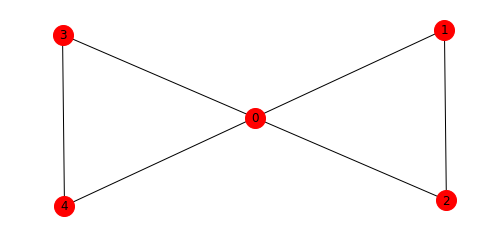

In [42]:
plt.figure(figsize = (6,3))
nx.draw(bowtie, node_size = 400, with_labels = True)
plt.show()